In [2]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy import misc
from glob import glob
import astropy.units as u
from PIL import Image
%matplotlib inline

## Problem 3

#### Using the lens equaion, write a program to lens a background source by a foreground mass.

In order to lens a background source, we split up each individual pixel, with pixel position x and y away form the corner of the image. In order to calculate the position of the source that will be displayed at (x,y), we use the following mathematics.

Here, we assume the following variable names:

$r$ :  radius between the lensed image and the projected deflector location

$r_{source}$ :  radius from source to projected deflector position

$x$ :  x position on lensed image

$y$ :  y position of lensed image

$x_{deflector}$ :  x position of deflector

$y_{deflector}$ :  y position of deflector

$x_{source}$ :  x position of source

$y_{source}$ :  y position of source

$p$ :  plate scale

$D_s$ :  horizontal distance between observer and source

$D_d$ :  horizontal distance between observer and deflector (i.e the massive lens)

$D_d\,s$ :  horizontal distance between deflector and source

$M$ :  mass of lens

$\beta$ :  angle between source and the deflector

$\theta$ :  angle between deflector $(x_{deflector},y_{deflector})$ and lensed image position $(x,y)$

$\theta_E$ :  angle projected to Einstien radius

$\mu$ : magnificaion of source

First, using the radius, we calculate $\theta$:

$$r = p \sqrt{(x-x_{deflector})^2 + (y-y_{deflector})^2}$$

$$\theta = \arctan(\frac{r}{d_s})$$

Using the lens equation, we can find beta:

$$ \beta = \theta - \frac{\theta_E^2}{\theta} $$ 

$$ \theta_E = \sqrt \frac{4 G M D_{d\,s}}{D_d D_s c^2} $$

Once beta is known, we can find the radius from the source to the deflector:

$$ r_{source} = \frac{D_s \tan(\beta)}{p}$$

Finally, to find the x and y pixel locations of the source on the image, and using the geometry to find a consistant value for cos and sin of beta, that will not result in unnecissary infinities:

$$x_{source} = x_{deflector} + r_{source} \cos \beta = x_{deflector} + r_{source} \frac{x-x_{deflector}}{r}$$

$$y_{source} = y_{deflector} + r_{source} \sin \beta = y_{deflector} + r_{source} \frac{y-y_{deflector}}{r}$$

We can also calculate the magnification of each pixel as follows:

$$ \mu = \frac{1}{1-(\frac{\theta_E}{\theta})^4} $$


We define the following constants and values, and define values s.t. the Einstein Radius is ~40 pixels.

In [13]:
G = 6.67408 * 10**-11 * u.m**3 /( u.kg * u.s**2)
c = 3 * 10**8 * u.m / u.s
M = 10**15 * u.kg 

x_def = 100
y_def = 100

d_d = 7 *10**40 * u.lyr
d_ds = 15 *10**30 * u.lyr
d_s = d_d + d_ds

plate_scale = .5 * u.pc

theta_E = (np.sqrt(4 * G * M * d_ds / (d_d * d_s * c**2)) * u.rad).decompose()

print 'Einstein Radius:',(theta_E * d_s / (plate_scale*u.rad) * u.pix).decompose()

Einstein Radius: 42.0525039243 pix


We define a function SourceCoord, which inputs the x and y pixel positions of the lensed image and outputs the x and y pixel positions of the origional source.

In [19]:
def SourceCoord(x,y,verbose):
    #Position x,y on lensed image
    
    #radius from x,y to deflector x_def,y_def
    r = ((x-x_def)**2 + (y-y_def)**2)**0.5 * plate_scale
#     if verbose == 'yesp
#         print 'r:', r
    
    # theta, angle from x,y to deflector
    theta = np.arctan(r/d_s)
#     if verbose == 'yes':
#         print 'theta:', theta, 'theta_E:', theta_E
    
    #beta, angle from x,y to source
    beta = theta - theta_E**2 / theta
#     if verbose == 'yes':
#         print 'beta:', beta
    
    #radius from source to deflector
    r_sou = np.copysign(((np.tan(beta) * d_s / plate_scale).decompose()),np.tan(beta))
#     if verbose == 'yes':
#         print 'source radius:', r_sou
        
    #source x and y positions
    x_sou = x_def + r_sou * plate_scale*(x-x_def)/r
    y_sou = y_def + r_sou * plate_scale*(y-y_def)/r
#     if verbose == 'yes':
#         print 'x source:', x_sou, 'x:', x, 'x deflector:', x_def
#         print 'y source:', y_sou, 'y:', y, 'y deflector:', y_def
    
    #magnification
    mu = 1/(1-(theta_E/theta)**4)
#     if verbose == 'yes':
#             print 'mu:', mu
    
    #returns source x and y positions
    if (x == x_def)&(y == y_def):
        return x_def,y_def
    else:
        return x_sou.value, y_sou.value

In [20]:
#testing limiting cases, to make sure they work
print SourceCoord(x_def,y_def,'yes')
print ''
print SourceCoord(x_def-30,y_def+30,'yes')
print ''
print SourceCoord(x_def+1,y_def+1,'yes')
print ''
print SourceCoord(x_def+100,y_def+100,'yes')

(100, 100)

(99.47355143836747, 100.52644856163253)

(-783.2065431510239, -783.2065431510239)

(191.15793456848974, 191.15793456848974)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in tan


The image to be lensed includes grids, and two circles, one at the center, behind the deflector, and one near the Einstien radius.

In [21]:
#building image3, to be lensed.
image3 = np.zeros([200,200,3])
image4 = np.zeros([200,200,3])

for i in range(0,1000,10):
    image3[i:i+1,:] = 100
    image3[:,i:i+1] = 100

image3[:,100:101] = [100,0,0]
image3[100:101,:] = [100,0,0]

lx, ly, lz = image3.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask_circle_1 = (X - lx *.5) ** 2 + (Y - ly *.2) ** 2 < lx * ly / 1000
mask_circle_2 = (X - lx *.5) ** 2 + (Y - ly *.5) ** 2 < lx * ly / 1000
mask_circle_3 = (X - lx *.5) ** 2 + (Y - ly * 42.053/200) ** 2 < (lx * ly) / (1000)


image3[mask_circle_1] = [0,100,0]
image3[mask_circle_2] = [0,0,100]
image3[mask_circle_3] = [0,1,1]

for i in range(10):
    val = i + 20
    mask_circle_3 = (X - lx *.5) ** 2 + (Y - ly * 40.63/200) ** 2 < (lx * ly) / (1000*val)
    mask_circle_2 = (X - lx *.5) ** 2 + (Y - ly *.5) ** 2 < lx * ly / (1000*val)

    image3[mask_circle_3] = [0,1,i*2]
    image3[mask_circle_2] = [0,0,i*2]

The following uses the SourceCoord function to find the lensed locations and build a new lensed image.

In [24]:
#image1[x position][y position][color]

for i in range(200):
    for j in range(200):
        x_sou, y_sou = SourceCoord(i, j, 'no')
        if (x_sou<200)&(x_sou>0)&(y_sou<200)&(y_sou>0) == True:
            image4[i][j] = image3[x_sou][y_sou]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in tan


#### Final plots, before/after lensing

The lens is marked by the red cross.

The image is marked by the blue circles.
    - The dark blue circle is behind the lens.
    - The light blue circle is just inside the E radius.

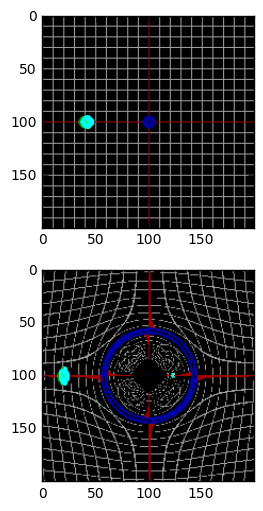

In [28]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(4,6)

ax[0].imshow(image3, cmap=plt.cm.gray);
ax[1].imshow(image4, cmap=plt.cm.gray);

 ## Problem 3 Extra Credit

In [29]:
image1 = misc.imread('hubble.gif')

n_x_pix = len(image1)
n_y_pix = len(image1[0])
print n_x_pix
print n_y_pix

image2 = np.zeros([n_x_pix,n_y_pix,3])

343
521


In [30]:
x_def = 150
y_def = 150
plate_scale = .25 * u.pc
theta_E = (np.sqrt(4 * G * M * d_ds / (d_d * d_s * c**2)) * u.rad).decompose()

print 'Einstein Radius:',(theta_E * d_s / (plate_scale*u.rad) * u.pix).decompose()

Einstein Radius: 84.1050078486 pix


In [32]:
#testing limiting cases, to make sure they work
print SourceCoord(x_def,y_def,'yes')
print ''
print SourceCoord(x_def-30,y_def+30,'yes')
print ''
print SourceCoord(x_def+1,y_def+1,'yes')
print ''
print SourceCoord(x_def+100,y_def+100,'yes')

(150, 150)

(237.89420575346986, 62.105794246530124)

(-3385.826172604096, -3385.826172604096)

(214.631738273959, 214.631738273959)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in tan


In [33]:
backup_image2 = image2

for i in range(n_x_pix):
    for j in range(n_y_pix):
        x_sou, y_sou = SourceCoord(i, j, 'no')
        if (x_sou<n_x_pix)&(x_sou>0)&(y_sou<n_y_pix)&(y_sou>0) == True:
            image2[i][j] = image1[x_sou][y_sou]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in tan


In [38]:
#generating correct RGB vs. BGR color plot, and inverting min to max and max to min

im2_max = image2.max()+1

image2_flipped = np.zeros([n_x_pix,n_y_pix,3])
for i in range(n_x_pix):
    for j in range(n_y_pix):
        image2_flipped[i][j][0] = im2_max-image2[i][j][0]
        image2_flipped[i][j][1] = im2_max-image2[i][j][1]
        image2_flipped[i][j][2] = im2_max-image2[i][j][2]

In [41]:
M = 10**5 * u.kg

x_def = 150
y_def = 230

d_d = 3.5 *10**40 * u.lyr
d_ds = 3.5 *10**40 * u.lyr
d_s = d_d + d_ds

plate_scale = .25 * u.pc

theta_E = (np.sqrt(4 * G * M * d_ds / (d_d * d_s * c**2)) * u.rad).decompose()

print 'Einstein Radius:',(theta_E * d_s / (plate_scale*u.rad) * u.pix).decompose()

Einstein Radius: 57.4546583002 pix


In [42]:
image2_2 = np.zeros([n_x_pix,n_y_pix,3])

In [43]:
backup_image2_2 = image2_2

for i in range(n_x_pix):
    for j in range(n_y_pix):
        x_sou, y_sou = SourceCoord(i, j, 'no')
        if (x_sou<n_x_pix)&(x_sou>0)&(y_sou<n_y_pix)&(y_sou>0) == True:
            image2_2[i][j] = image2[x_sou][y_sou]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in tan


In [58]:
#generating correct RGB vs. BGR color plot, and inverting min to max and max to min

im2_2_max = image2.max()+1

image2_2_flipped = np.zeros([n_x_pix,n_y_pix,3])
for i in range(n_x_pix):
    for j in range(n_y_pix):
        image2_2_flipped[i][j][0] = im2_2_max-image2_2[i][j][0]
        image2_2_flipped[i][j][1] = im2_2_max-image2_2[i][j][1]
        image2_2_flipped[i][j][2] = im2_2_max-image2_2[i][j][2]

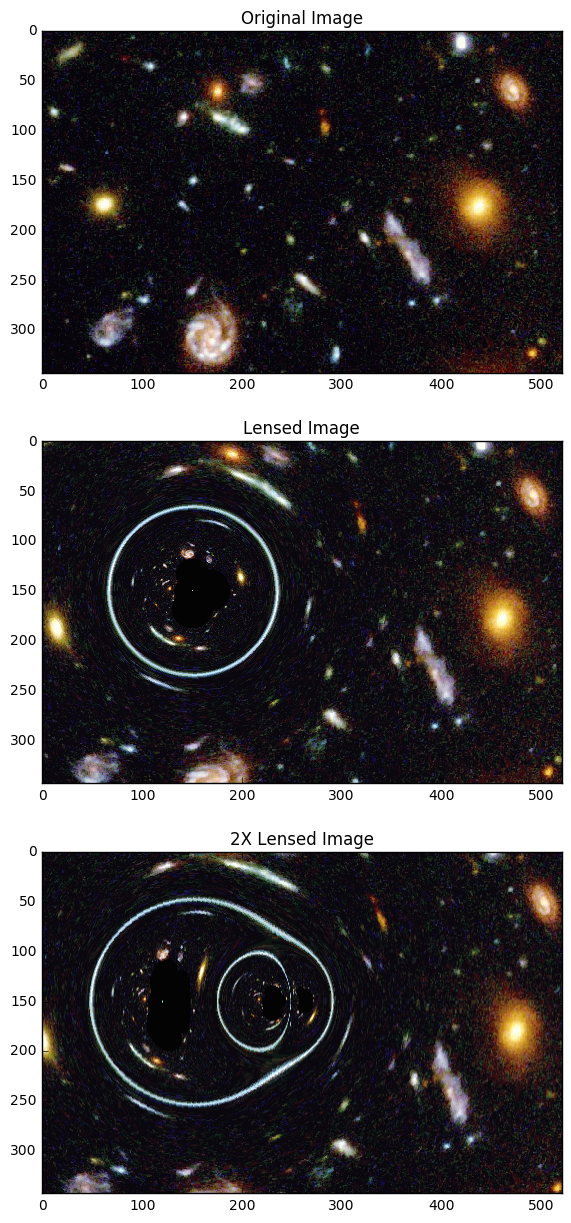

In [59]:
fig,ax = plt.subplots(3,1)
fig.set_size_inches(7,15)

ax[0].set_title('Original Image',fontsize=12)
ax[0].imshow(image1, cmap=plt.cm.gray);

ax[1].set_title('Lensed Image',fontsize=12)
ax[1].imshow(image2_flipped, cmap=plt.cm.gray);

ax[2].set_title('2X Lensed Image',fontsize=12)
ax[2].imshow(image2_2_flipped, cmap=plt.cm.gray);